Why DIRECT? in this paper, the threats have been simplified to circular boundaries. In real life, the boundaries will be irregular, and will have no explicit differentiable expression avalible.

In [1]:
from scipy.optimize import direct
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle, Patch

s# Deriving the cost function.

## Finding an initial cost function

* Consider problem in two dimensions.
* Route consists of start and endpoints with a number of intermediate waypoints.
* The coordinates of the waypoints are the optimization variables.
* We want the distance flown to be minimal, so calculate Euclidian distance of the route, and label it $L$.
* Determine if any of our path lies within a threat, and the length of the path within the threat.

If the route lies within the $i$-th threat for a distance $L_i$ then the cost of the route can be expressed as

$C = L + \displaystyle\sum_{i} \rho _i L_{i}^{rho}$

$\rho _i$ is a penalty parameter for the $i$-th threat.

In other words, the cost is the total length of the path, plus the length of each segment within a threat multiplied by the penalty parameter associated with that particular threat.

## Defining "leg" length
We have $n$ waypoints $w_j = (w_{j1}, w_{j2})$ for $j = 1, ..., n$, let the start and end points be $w_0, w_{n+1}$ respectively. We can define the vector $u_j = w_j - w_{j-1}$ which helps us defined the length of any given leg as 

$l_j = \sqrt{(u_{j1}^2 + u_{j2}^2)}$

## Determining threat violations

We  will use linear interpoliation to estimate where leg $j$ intersects with threat $i$. 

Consider $\sigma _{max}$ to be the maximum step size for use in sampling any leg of a route. This means that the number of samplings points along leg $j$ is $K_{max} = \lceil l_j / \sigma _{max} \rceil$.Let the normalized step size be $\delta \lambda = \frac{1}{K_{max}}$ and let $u_k$ be a sampled point in the leg.

$u_k = w_{j-1} + k \delta \lambda (w_j - w_{j-1})$

$k = [0, ..., K_{max}]$.

Suppose we have an indicator function of position, $T_i$, such that $T_i(u_k) \leq 0$ indicates that the sampled position within the leg, $u_k$ is within threat i, and confirms that the position is not within the threat otherwise. Using what we have defined so far can create an algorithm for calculating "in threat" length, denoted $l_{ji}$.

1. Find $l_j$, $l_i$. Set $i_{ji} = 0$  
2. Set $k=0$, $K_{max}=(\delta \lambda)^{-1}$  
3. If $T_i (u_0) \leq 0$ then $\lambda _b = 0$  
4. For $k = 1, ..., K_{max}$   
5.  ---> If $T_i (u_k) \leq 0$ and $T_i (u_{k-1}) > 0$ then  
6.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _b = (k - \kappa)\delta \lambda$  
7.  ---> If $T_i (u_k) > 0$ and $T_i (u_{k-1}) \leq 0$ then  
8.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _e = (k - \kappa)\delta \lambda$  
9.  ------->  set $l_{ji} + (\lambda _e - \lambda _b) l_j$  
10.  ---> If $T_i (u_{K_{max}}) \leq 0$ then   
11.  -------> set $l_{ji} = l_{ji} + (1- \lambda _b )l_j$  

Line-by-line explanation:

1. Find the length of the current leg. Initialize "in threat" distance accumulator as 0.
2. Set up a counter at 0, and set $K_{max} = (\delta \lambda)^{-1}$. Recall: $\delta \lambda = 1/K_{max}$. So we're just initializing $K_{max}$ with it's own value.
3. Determine if our starting point is within the threat.
4. For k = 1 -> $K_{max}$ to start checking each point along the leg.
5. Detect if the path passed INTO the threat.
6. Calculate the location of the boundary with interpolation. $\kappa$ is the fractional interpolation value, it represents a number from 0-1 that says where the boundary crossing lies between two samples on the leg. After that, we calculate where the crossing occurs on the entire leg. We know the crossing occured when we took the k-th step. So $k-\kappa$ is the number of steps to where the boundary is, and $\delta \lambda$ is our step size.
7. Detect if the passed passed OUT of the threat
8. Perform the same interpolation as step 6. Set $\lambda _e$ instead which is the exit position.
9. Since we've exited, we can calculate the in-threat distance, $l_{ji}$. $(\lambda _e - \lambda _b)$ represents the normalized distance in the threat zone and multiplying it by $l_j$ converts it to real distance. Add it to the accumulator. 
10. Determine if exit point is inside the threat
11. Do a similar calculation to step 9, add it to the accumulator.
 
## Defining constraints
Two additional features are included to enhance the realism of the simulation. Firstly, you can restrict routes that involve sharp turns, and secondly, you can set a limit on the distance between waypoints.

The angle between successive legs is defined as $\phi _j$. Given by

$\phi _j = cos^{-1}\{\frac{u_j ^T u_{j+1}}{||u_j|| ||u_{j+1}||}\}$

$\phi _{max}$ is the limiting turn angle, and $l_{min}$ is the minimum leg-length. We can define a final extended cost function.

$$
C = \sum_{j=1}^{n+1} ( l_j + \mu (( l_{min} - l_j )_+ )^2 + \sum_{j=1}^m \rho _i l_{ji}^{\rho} ) + \sum_{j=1}^n v ((\phi _j - \phi _{max})_+)^2
$$

$\mu$ and $v$ are positive penalty parameters for controling minimum leg length and turn angle.

## Helper functions

In [2]:
def T_i(point: np.ndarray, center: np.ndarray, radius: int) -> float:
    """Calculate the distance from a point to the threat zone, negative value indicates inside the zone"""
    return np.linalg.norm(point - center) - radius

def in_threat_distance(start: np.ndarray, end: np.ndarray, center: np.ndarray, radius: int, sigma_max: int) -> float:  
    """Calculate the in-threat distance of a leg"""

    l_j = np.linalg.norm(end - start) # Magnitude of the leg vector
    if l_j == 0: # Check if leg-length is zero
        return 0 
    l_ji = 0.0  # initialize in-threat distance accumulator
    K_max = int(np.ceil(l_j / sigma_max))  # The total number of samples along the leg
    delta_lambda = 1 / K_max # Step size

    # If the starting point is inside the threat zone, set lambda_b to 0
    if T_i(start, center, radius) <= 0:
        lambda_b = 0

    # Loop through each step along the leg
    for k in range(1, K_max+1):
        lambda_k = k * delta_lambda # Current normalized distance along the leg. k = num steps and delta_lambda = normalized step size
        u_k = start + lambda_k * (end - start) # Current point along the leg. lambda_k * (end - start) = Actual point on the leg (not normalized)
        T_k = T_i(u_k, center, radius) # Calculate the distance from the current point to the threat zone

        u_k_prev = start + (lambda_k - delta_lambda) * (end - start) # Previous point along the leg
        T_k_prev = T_i(u_k_prev, center, radius) # Calculate the distance from the previous point to the threat zone

        # Entering threat zone, meaning current point is inside and the previous was outside
        if T_k <= 0 and T_k_prev > 0:
            kappa = T_k / (T_k - T_k_prev) # Ratio of the distance to the threat zone at the current point to the distance at the previous point
            lambda_b = (k - kappa) * delta_lambda # Normalized distance at which the leg enters the threat zone
        
        # Exiting threat zone, meaning the current point is outside and the previous was inside
        if T_k > 0 and T_k_prev <= 0:
            kappa = T_k / (T_k - T_k_prev) # Same as above, but for exiting the zone
            lambda_e = (k - kappa) * delta_lambda # Normalized distance at which the leg exits the threat zone
            l_ji += (lambda_e - lambda_b) * l_j # Accumulate the in-threat distance since we have now exited the zone
            lambda_b = None # Reset lambda_b for the next leg
    
    # If ending inside threat zone
    if T_i(end, center, radius) <= 0 and lambda_b is not None:
        l_ji += (1.0 - lambda_b) * l_j # Accumulate the in-threat distance 
    return l_ji

def calculate_path_length(waypoints: np.ndarray) -> np.float64:
    """Calculate the length of a path defined by waypoints"""
    legs = np.diff(waypoints, axis=0)
    return np.sum(np.linalg.norm(legs, axis=1))

def calculate_max_turn_angle(waypoints: np.ndarray) -> float:
    """Calculate the maximum turn angle for a given path"""
    legs = np.diff(waypoints, axis=0)
    turn_angles = [
        np.degrees(np.arccos(np.clip(
            np.dot(legs[j-1], legs[j]) / (np.linalg.norm(legs[j-1]) * np.linalg.norm(legs[j])),
            -1, 1
        )))
        for j in range(1, len(legs))
    ]
    return max(turn_angles) if turn_angles else 0

def print_report(result, origin, destination, threats):
    out_waypoints = result.x.reshape(-1, 2)
    out_cost = result.fun

    # Calculate the path length
    outbound_path = np.vstack([origin, out_waypoints, destination])
    outbound_length = calculate_path_length(outbound_path)

    # Calculate maximum turn angle
    max_turn_angle = calculate_max_turn_angle(outbound_path)

    # Calculate total threat violation distance
    total_threat_violation = sum(
        in_threat_distance(outbound_path[j], outbound_path[j+1], center, radius, sigma_max=4.0)
        for j in range(len(outbound_path) - 1)
        for center, radius in threats
    )

    print(f"Path length: {outbound_length:.2f} km")
    print(f"Cost: {out_cost:.2f}")
    print(f"Maximum turn angle: {max_turn_angle:.2f} degrees")
    print(f"Total threat violation distance: {total_threat_violation:.2f} km")
    print(f"Number of function calls: {result.nfev}") 

    print(f"\nWaypoints:")
    for i in out_waypoints:
        print(f"  ({i[0]:.2f}, {i[1]:.2f})")
    print()

def create_bounds(lb, ub):
    """Takes in a list of waypoints and tolerances, returns bounding boxes for matplotlib
    
    returns 3 items in a list per waypoint:
    1. Tuple containing xmin and ymin
    2. width
    3. height"""
    lb = np.array(lb)
    ub = np.array(ub)
    boxes = []
    lb = lb.reshape(-1, 2)
    ub = ub.reshape(-1, 2)
    for i in range(len(lb)):
        boxes.append([(lb[i][0], lb[i][1]), ub[i][0]-lb[i][0], ub[i][1]-lb[i][1]])
    return boxes
    

# Cost function

In [3]:
def cost(waypoint_coords: np.ndarray, # Flat representation of waypoints, i.e. (1, 6) and (2, 4) represented as [1, 6, 2, 4]
        start: np.ndarray, # Start point of the path
        end: np.ndarray, # End point of the path
        threats: list, # List of tuples, each containing a threat center and radius. Threat center is a np.ndarray like start and end
        lmin: int, # Minimum leg length
        phi_max: np.float64, # Maximum turn angle in radians
        mu: int, # Penalty for leg length
        nu: int, # Penalty for turn angle
        rho: int, # Penalty for threat distance
        sigma_max=4.0) -> np.float64: # Maximum step size for sampling

    PENALTY_EXPONENT = 3 # Exponent for the in threat distance penalty

    # Get a list of all the waypoints in order.
    # reshape(-1, 2) converts the flat representation into a 2D array of shape (n, 2)
    # vstack puts the start and end points into the correct positions.
    waypoints = np.vstack([start, waypoint_coords.reshape(-1, 2), end]) 

    # Calculate each leg length
    legs = np.diff(waypoints, axis=0) # Get the vector representation of each leg
    leg_lengths = np.linalg.norm(legs, axis=1) # Compute the magnitude of each leg vector

    # Calculate turn angles
    turn_angles = []
    for j in range(1, len(legs)): # Start from the second leg because the first leg has no previous leg to compare to
        dot_product = np.dot(legs[j-1], legs[j]) 
        norm_prev = np.linalg.norm(legs[j-1]) # Magnitude of the previous leg (magnitude = norm = length for vectors)
        norm_curr = np.linalg.norm(legs[j])  
        cos_phi = dot_product / (norm_prev * norm_curr) # Normalize the dot product to get the cosine of the angle, Definition of dot product: u⋅v = |u||v|cosθ
        angle = np.arccos(np.clip(cos_phi, -1, 1)) # Use arccos to get the angle from the cosine value. np.clip prevents out-of-bounds errors.
        turn_angles.append(angle)

    #turn_angles = [ np.arccos(np.clip(np.dot(legs[j-1], legs[j]) / (np.linalg.norm(legs[j-1]) * np.linalg.norm(legs[j])), -1, 1)) for j in range(1, len(legs)) ]
    
    # Calculate total cost
    total_cost = np.sum(leg_lengths) # Total path length
    total_cost += np.sum(mu * np.maximum(lmin - leg_lengths, 0) ** 2) # Leg length penalties
    
    # PENALTY WITH DEGREES, this was so important to figure out.
    total_cost += np.sum(nu * np.maximum(np.degrees(turn_angles) - np.degrees(phi_max), 0) ** 2) # Turn angle penalties
    
    # PENALTY WITH RADIANS
    #total_cost += np.sum(nu * np.maximum(turn_angles - phi_max, 0) ** 2) # Turn angle penalties

    # Threat penalties
    for threat_centre, threat_radius in threats:
        # Calculate and sum the in-threat distance of each leg
        l_ji = sum(in_threat_distance(waypoints[j], waypoints[j+1], threat_centre, threat_radius, sigma_max) for j in range(len(legs)))
        total_cost += rho * (l_ji ** PENALTY_EXPONENT)

    return total_cost

## Approach #1 - Separate calculation of outward and return legs.
### From the paper:
- Assume two waypoints will be sufficient placed along the midline.
- (108 ± 60, 68 ± 40), (109 ± 60, 69 ± 40)
- Set parameters as $\mu = \nu = \rho _i = 1$
- Do 64 iterations of DIRECT

Results from paper: (68, 77), (125, 105) with length of 155.6 km. No threat violations, maximum turn angle of $43.2^{\circ}$. Costing 1343 function calls.


In [4]:
threats = [ 
    (np.array([75,  29]),    9),    
    (np.array([80,  66]),    15),   
    (np.array([95,  115]),   22.5), 
    (np.array([135, 131]),   20),   
    (np.array([140, 67.5]),  37.5), 
    (np.array([197, 125]),   30)    
] 

origin = np.array([50, 30])
destination = np.array([167, 107])

# Initial bounds for the waypoints
lb = [108 - 60, 68 - 40, 109 - 60, 69 - 40]
ub = [108 + 60, 68 + 40, 109 + 60, 69 + 40]

phi_max = np.radians(42.5)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 1# Penalty for turn angle
rho = 1 # Penalty for threat distance

print("=== Optimizing Outbound Leg ===")
result = direct(lambda waypoint_coords: cost(waypoint_coords, origin, destination, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                bounds=list(zip(lb, ub)),
                maxiter=64,
                maxfun=8000,
                locally_biased=False) 
print(result.message)
print_report(result, origin, destination, threats)


=== Optimizing Outbound Leg ===
Number of iterations is larger than maxiter=64
Path length: 155.46 km
Cost: 155.51
Maximum turn angle: 42.72 degrees
Total threat violation distance: 0.00 km
Number of function calls: 5285

Waypoints:
  (68.18, 76.78)
  (124.56, 104.32)



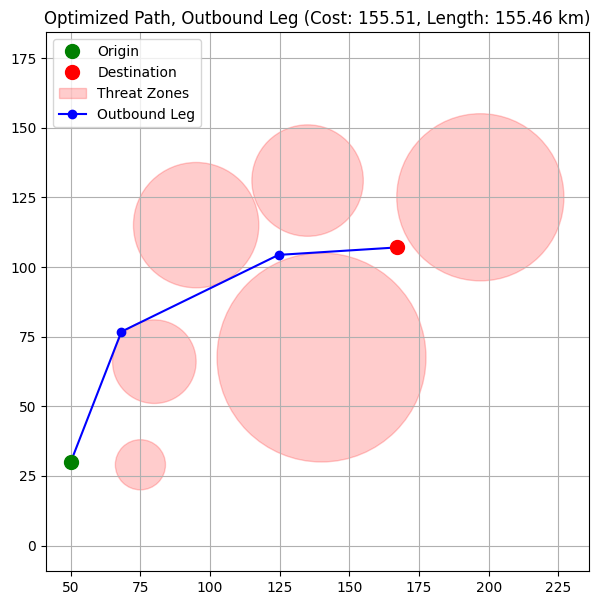

In [5]:
# Plotting 64 iterations
out_waypoints = result.x.reshape(-1, 2)

plt.figure(figsize=(7, 7))

path_line, = plt.plot(
    np.vstack([origin, out_waypoints, destination])[:, 0], # X-coordinates of the path
    np.vstack([origin, out_waypoints, destination])[:, 1], # Y-coordinates of the path
    'b-o', 
    label='Outbound Leg'
)

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create a legend entry for threats (using Patch)
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')


plt.legend(handles=[origin_dot, dest_dot, threat_patch, path_line], loc='upper left')
plt.axis('equal')
plt.grid()
plt.title(f"Optimized Path, Outbound Leg (Cost: {result.fun:.2f}, Length: {calculate_path_length(np.vstack([origin, out_waypoints, destination])):.2f} km)")
plt.show()


## Running the experiment again with 128 iterations

In [6]:
# Initial bounds for the waypoints
lb = [108 - 60, 68 - 40, 109 - 60, 69 - 40]
ub = [108 + 60, 68 + 40, 109 + 60, 69 + 40]

phi_max = np.radians(42.5)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 1# Penalty for turn angle
rho = 1 # Penalty for threat distance

print("=== Optimizing Outbound Leg ===")
result = direct(lambda waypoint_coords: cost(waypoint_coords, origin, destination, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                bounds=list(zip(lb, ub)),
                maxiter=128,
                maxfun=16000,
                locally_biased=False) 
print(result.message)
print_report(result, origin, destination, threats)


=== Optimizing Outbound Leg ===
Number of iterations is larger than maxiter=128
Path length: 155.43 km
Cost: 155.48
Maximum turn angle: 42.72 degrees
Total threat violation distance: 0.05 km
Number of function calls: 13475

Waypoints:
  (68.24, 76.82)
  (124.56, 104.29)



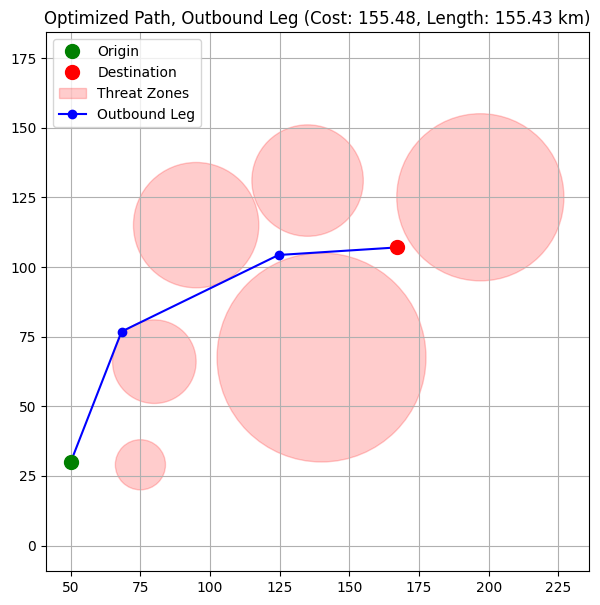

In [7]:
# Plotting 128 iterations
out_waypoints = result.x.reshape(-1, 2)

plt.figure(figsize=(7, 7))

path_line, = plt.plot(
    np.vstack([origin, out_waypoints, destination])[:, 0], # X-coordinates of the path
    np.vstack([origin, out_waypoints, destination])[:, 1], # Y-coordinates of the path
    'b-o', 
    label='Outbound Leg'
)

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create a legend entry for threats (using Patch)
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')


plt.legend(handles=[origin_dot, dest_dot, threat_patch, path_line], loc='upper left')
plt.axis('equal')
plt.grid()
plt.title(f"Optimized Path, Outbound Leg (Cost: {result.fun:.2f}, Length: {calculate_path_length(np.vstack([origin, out_waypoints, destination])):.2f} km)")
plt.show()


### Running the outbound leg in restart mode after 64 steps

In [8]:
#Previously obtained results.
lb = [68 - 60, 77 - 40, 128 - 60, 104 - 40]  
ub = [68 + 60, 77 + 40, 128 + 60, 104 + 40]

phi_max = np.radians(42.5)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 1 # Penalty for turn angle
rho = 1 # Penalty for threat distance

print("=== Optimizing Outbound Leg ===")
result = direct(lambda waypoint_coords: cost(waypoint_coords, origin, destination, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                bounds=list(zip(lb, ub)),
                maxiter=64,
                maxfun=8000,
                locally_biased=False) 
                
print(result.message)
print_report(result, origin, destination, threats)

=== Optimizing Outbound Leg ===
The volume of the hyperrectangle containing the lowest function value found is below vol_tol=1e-16
Path length: 155.43 km
Cost: 155.47
Maximum turn angle: 42.72 degrees
Total threat violation distance: 0.00 km
Number of function calls: 6993

Waypoints:
  (68.24, 76.84)
  (124.31, 104.18)



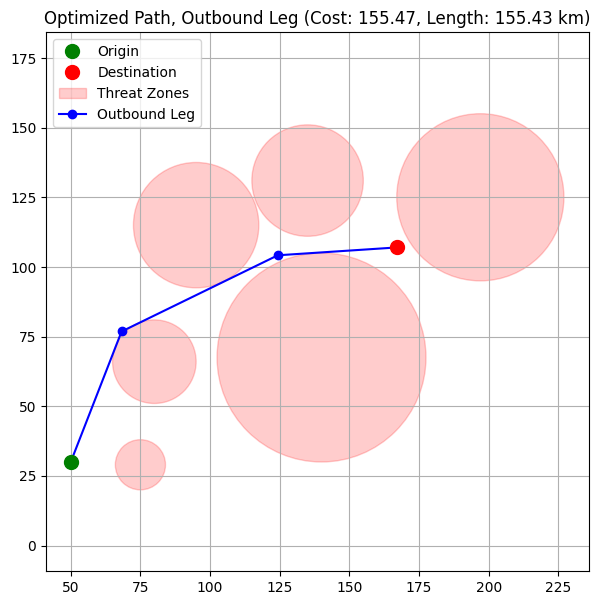

In [9]:
# Plotting Resstart mode
out_waypoints = result.x.reshape(-1, 2)

plt.figure(figsize=(7, 7))

path_line, = plt.plot(
    np.vstack([origin, out_waypoints, destination])[:, 0], # X-coordinates of the path
    np.vstack([origin, out_waypoints, destination])[:, 1], # Y-coordinates of the path
    'b-o', 
    label='Outbound Leg'
)

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

plt.legend(handles=[origin_dot, dest_dot, threat_patch, path_line], loc='upper left')
plt.axis('equal')
plt.grid()
plt.title(f"Optimized Path, Outbound Leg (Cost: {result.fun:.2f}, Length: {calculate_path_length(np.vstack([origin, out_waypoints, destination])):.2f} km)")
plt.show()


##  Using a third waypoint
"Since the turning angle constraint has not yet been satisfied, a possible strategy would
be to increase the parameter ν in (2.2). However it may be easier just to insert an extra
waypoint and solve the problem again. This remark is well worth making because further
experiments (not reported in detail here) suggest that it is not possible to obtain a feasible
route with just two waypoints. Specifically, when ν is increased, DIRECT is able to find
approximate minima of (2.2) which involve smaller turning angles; but this happens only
at the expense of threat violations."

Previously obtained result:
(68.24, 77.06)
(128.50, 104.40)
and placing an extra point between them.
(97, 91)

In [10]:
lb = [68 - 5, 77 - 5, 97 - 30, 91 - 14, 128 - 5, 104 - 5]
ub = [68 + 5, 77 + 5, 97 + 30, 91 + 14, 128 + 5, 104 + 5]

phi_max = np.radians(42.5)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 1# Penalty for turn angle
rho = 1 # Penalty for threat distance

print("=== Optimizing Outbound Leg ===")
result = direct(lambda waypoint_coords: cost(waypoint_coords, origin, destination, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                bounds=list(zip(lb, ub)),
                maxiter=128,
                maxfun=16000,
                locally_biased=False) 
print(result.message)
print_report(result, origin, destination, threats)


=== Optimizing Outbound Leg ===
The volume of the hyperrectangle containing the lowest function value found is below vol_tol=1e-16
Path length: 155.01 km
Cost: 155.01
Maximum turn angle: 33.58 degrees
Total threat violation distance: 0.00 km
Number of function calls: 9753

Waypoints:
  (67.44, 75.38)
  (77.74, 82.70)
  (129.66, 104.56)



## Calculation of return leg
We will include the last leg of the outward leg to prevent the route from doing a pivot turn and retracing the same path.

The last waypoint from the previous path is
  (129.66, 104.56)
So the last leg is from that point to the destination. 
To ensure the "destination" point doesn't move we enclose it with a -+ 0.1 bounding box.

In [11]:
lb = [
    167 - 0.1, 107 - 0.1, # Destination box
    106 - 50, 64 - 75,
    107 - 50, 65 - 75,
    108 - 50, 66 - 75,
    109 - 50, 67 - 75]

ub = [
    167 + 0.1, 107 + 0.1,
    106 + 125, 64 + 75,
    107 + 125, 65 + 75,
    108 + 125, 66 + 75,
    109 + 125, 67 + 75]

last_waypoint = np.array([129.66, 104.56])

phi_max = np.radians(30)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 10 # Penalty for turn angle
rho = 1 # Penalty for threat distance

print("=== Optimizing Outbound Leg ===")
# Note that origin has changed to last waypoint, and destination is changed to origin.
result = direct(lambda waypoint_coords: cost(waypoint_coords, last_waypoint, origin, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                bounds=list(zip(lb, ub)),
                maxiter=512,
                maxfun=120000,
                vol_tol=0,
                locally_biased=False) 
print(result.message)
print_report(result, last_waypoint, origin, threats)


=== Optimizing Outbound Leg ===
Number of function evaluations done is larger than maxfun=120000
Path length: 285.83 km
Cost: 6595.54
Maximum turn angle: 41.50 degrees
Total threat violation distance: 4.64 km
Number of function calls: 120165

Waypoints:
  (167.01, 106.90)
  (195.35, 85.40)
  (202.11, 53.07)
  (184.15, 21.56)
  (122.97, 0.33)



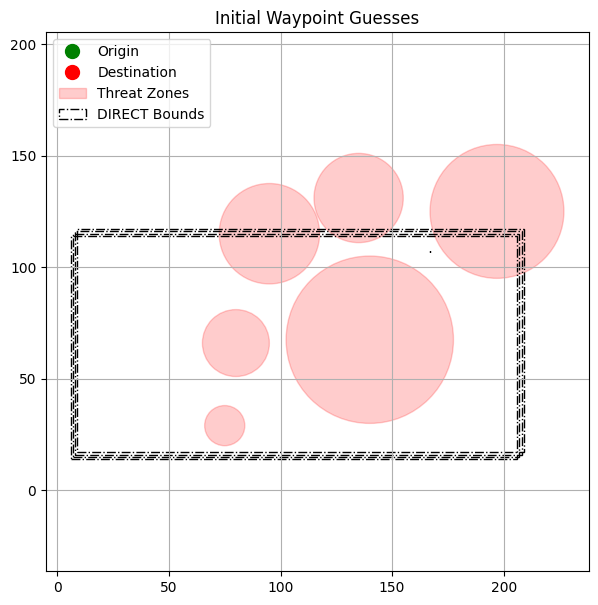

In [12]:
# Return leg setup plot
plt.figure(figsize=(7, 7))

# Plot threat zones
for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create waypoints and bounds
lb = [
    167 - 0.1, 107 - 0.1, # Destination box
    106 - 100, 64 - 50,
    107 - 100, 65 - 50,
    108 - 100, 66 - 50,
    109 - 100, 67 - 50]

ub = [
    167 + 0.1, 107 + 0.1,
    106 + 100, 64 + 50,
    107 + 100, 65 + 50,
    108 + 100, 66 + 50,
    109 + 100, 67 + 50]
waypoints = np.array([167, 107, 106, 64, 107, 65, 108, 66, 109, 67]).reshape(-1, 2)

# Plot bounding boxes
boxes = create_bounds(lb, ub)
for i in boxes:
    rect = Rectangle(i[0], i[1], i[2], linewidth=1, edgecolor='black', 
                    facecolor='None', label="DIRECT Bounds", linestyle="-.")
    plt.gca().add_patch(rect)

# Plot origin and destination 
#origin_dot, = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin')
#dest_dot, = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination')

# Create threat zone patch
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

# Create legend with all elements
plt.legend(handles=[origin_dot, dest_dot, threat_patch, rect], 
           loc='upper left')

plt.axis('equal')
plt.grid()
plt.title("Initial Waypoint Guesses")
plt.show()

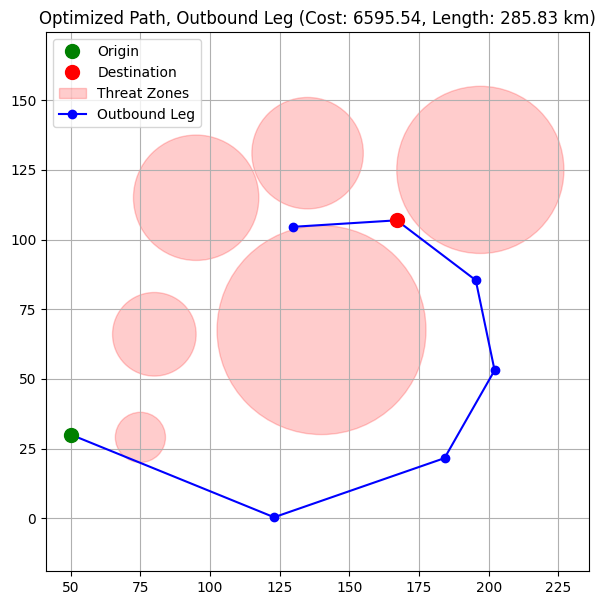

In [13]:
# Plotting Return Leg
out_waypoints = result.x.reshape(-1, 2)

plt.figure(figsize=(7, 7))

path_line, = plt.plot(
    np.vstack([last_waypoint, out_waypoints, origin])[:, 0], # X-coordinates of the path
    np.vstack([last_waypoint, out_waypoints, origin])[:, 1], # Y-coordinates of the path
    'b-o', 
    label='Outbound Leg'
)

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

plt.legend(handles=[origin_dot, dest_dot, threat_patch, path_line], loc='upper left')
plt.axis('equal')
plt.grid()
plt.title(f"Optimized Path, Outbound Leg (Cost: {result.fun:.2f}, Length: {calculate_path_length(np.vstack([last_waypoint, out_waypoints, origin])):.2f} km)")
plt.show()


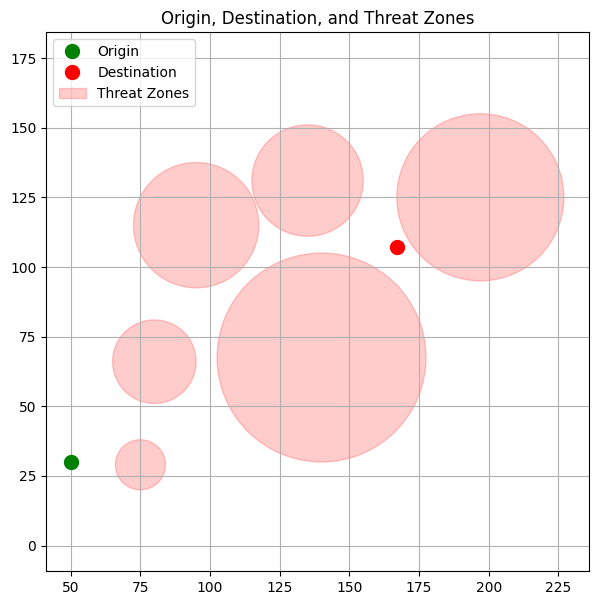

In [14]:
plt.figure(figsize=(7, 7))

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

# Add threat zones
for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create a legend entry for threats (using Patch)
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

plt.legend(handles=[origin_dot, dest_dot, threat_patch], loc='upper left')

plt.axis('equal')
plt.grid()
plt.title("Origin, Destination, and Threat Zones")
plt.show()

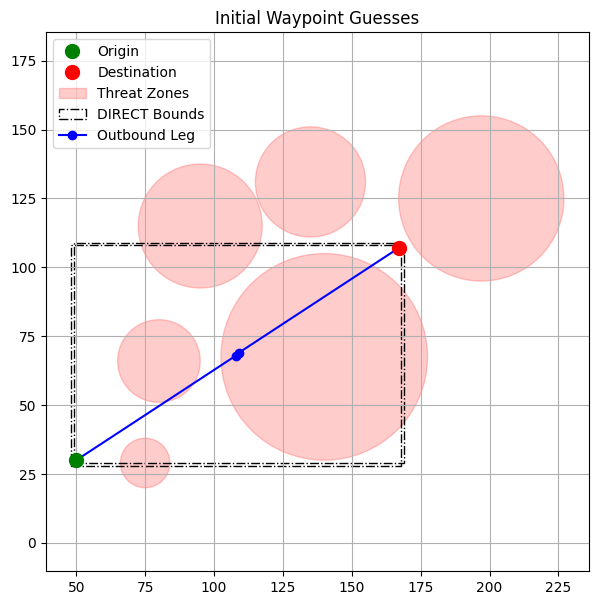

In [15]:
plt.figure(figsize=(7, 7))

# Plot threat zones
for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create waypoints and bounds
lb = [108 - 60, 68 - 40, 109 - 60, 69 - 40]  
ub = [108 + 60, 68 + 40, 109 + 60, 69 + 40]
waypoints = np.array([108, 68, 109, 69]).reshape(-1, 2)

# Plot the path and store its handle
path_line, = plt.plot(
    np.vstack([origin, waypoints, destination])[:, 0],
    np.vstack([origin, waypoints, destination])[:, 1],
    'b-o', 
    label='Outbound Leg'
)

# Plot bounding boxes
boxes = create_bounds(lb, ub)
for i in boxes:
    rect = Rectangle(i[0], i[1], i[2], linewidth=1, edgecolor='black', 
                    facecolor='None', label="DIRECT Bounds", linestyle="-.")
    plt.gca().add_patch(rect)

# Plot origin and destination (store handles)
origin_dot, = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin')
dest_dot, = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination')

# Create threat zone patch
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

# Create legend with all elements
plt.legend(handles=[origin_dot, dest_dot, threat_patch, rect, path_line], 
           loc='upper left')

plt.axis('equal')
plt.grid()
plt.title("Initial Waypoint Guesses")
plt.show()

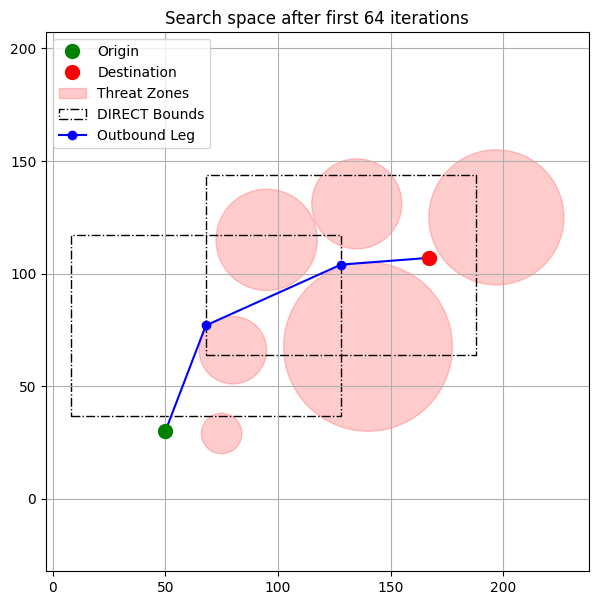

In [16]:
plt.figure(figsize=(7, 7))

# Plot threat zones
for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create waypoints and bounds
lb = [68 - 60, 77 - 40, 128 - 60, 104 - 40]  
ub = [68 + 60, 77 + 40, 128 + 60, 104 + 40]
waypoints = np.array([68, 77, 128, 104]).reshape(-1, 2)

# Plot the path and store its handle
path_line, = plt.plot(
    np.vstack([origin, waypoints, destination])[:, 0],
    np.vstack([origin, waypoints, destination])[:, 1],
    'b-o', 
    label='Outbound Leg'
)

# Plot bounding boxes
boxes = create_bounds(lb, ub)
for i in boxes:
    rect = Rectangle(i[0], i[1], i[2], linewidth=1, edgecolor='black', 
                    facecolor='None', label="DIRECT Bounds", linestyle="-.")
    plt.gca().add_patch(rect)

# Plot origin and destination (store handles)
origin_dot, = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin')
dest_dot, = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination')

# Create threat zone patch
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

# Create legend with all elements
plt.legend(handles=[origin_dot, dest_dot, threat_patch, rect, path_line], 
           loc='upper left')

plt.axis('equal')
plt.grid()
plt.title("Search space after first 64 iterations")
plt.show()


## Approach 3 - Building a complete route by adding waypoints.
Perform M iterations of DIRECT on the full out-and-return problem with small number of waypoints.

Add a waypoint to any leg which passes through a threat, with this new waypoint's enclosing box is between the two other waypoints.

Reduce the box around the "old" waypoints by a factor of kappa.

Run for M more iterations.

Do not add a new length if the leg length is less than 2lmin.

Continue until two successive cycles of DIRECT product approximately the same value for the cost function.


In [18]:
# Adaptive DIRECT optimization with waypoint insertion

def find_legs_in_threat(waypoints, threats, sigma_max=4.0):
    """Find legs that pass through a threat
    Returns a list of indices of legs that are in threat zones"""
    legs_in_threat = []
    for j in range(len(waypoints) - 1):
        for center, radius in threats:
            if in_threat_distance(waypoints[j], waypoints[j+1], center, radius, sigma_max) > 0:
                legs_in_threat.append(j)
                break
    return sorted(set(legs_in_threat))

# Parameters
M = 64
phi_max = np.radians(42.5)  # Set phi max, max turn angle
lmin = 10 # Minimum leg length
mu = 1 # Penalty for leg length
nu = 10 # Penalty for turn angle
rho = 1 # Penalty for threat distance
kappa = 0.7 # Reduction factor for bounding boxes


origin = np.array([50, 30])
destination = np.array([167, 107])
start = origin
end = origin # Round trip

lb = [
    109 - 100, 67 - 50, 
    167 - 0.1, 107 - 0.1,
    109 - 100, 67 - 50,]

ub = [
    109 + 100, 67 + 50, 
    167 + 0.1, 107 + 0.1,
    109 + 100, 67 + 50,]

prev_cost = None
tol = 1e-2
max_cycles = 10
for cycle in range(max_cycles):
    print(f"\n=== DIRECT cycle {cycle+1} with {len(lb)//2} waypoints ===")

    result = direct(lambda waypoint_coords: cost(waypoint_coords, start, end, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                   bounds=list(zip(lb, ub)),
                   maxiter=M,
                   maxfun=8000,
                   locally_biased=False)
    
    print_report(result, start, end, threats)

    waypoints = np.vstack([start, result.x.reshape(-1, 2), end])

    # Find legs that pass through a threat and are longer than 2*lmin
    legs_in_threat = find_legs_in_threat(waypoints, threats)
    inserted = False
    for leg_num in reversed(legs_in_threat):
        leg_len = np.linalg.norm(waypoints[leg_num+1] - waypoints[leg_num])
        if leg_len > 2*lmin:
            # Insert waypoint and update bounds
            lb_arr = np.array(lb).reshape(-1, 2)
            ub_arr = np.array(ub).reshape(-1, 2)
            new_lb = np.minimum(waypoints[leg_num], waypoints[leg_num+1])
            new_ub = np.maximum(waypoints[leg_num], waypoints[leg_num+1])
            lb_arr = np.insert(lb_arr, leg_num+1, new_lb)
            ub_arr = np.insert(ub_arr, leg_num+1, new_ub)
            # Reduce boxes by kappa
            centers = (lb_arr + ub_arr) / 2
            half_sizes = (ub_arr - lb_arr) * kappa / 2
            lb_arr = centers - half_sizes
            ub_arr = centers + half_sizes
            lb = lb_arr.flatten().tolist()
            ub = ub_arr.flatten().tolist()
            inserted = True
    if not inserted:
        # No new waypoints inserted, check for convergence
        if prev_cost is not None and abs(result.fun - prev_cost) < tol:
            print(f"Converged after {cycle+1} cycles.")
            break
        prev_cost = result.fun


=== DIRECT cycle 1 with 3 waypoints ===
Path length: 391.14 km
Cost: 103156.41
Maximum turn angle: 110.61 degrees
Total threat violation distance: 70.20 km
Number of function calls: 6311

Waypoints:
  (195.42, 27.49)
  (167.03, 107.10)
  (74.43, 92.93)


=== DIRECT cycle 2 with 6 waypoints ===
Path length: 577.96 km
Cost: 484541.52
Maximum turn angle: 168.68 degrees
Total threat violation distance: 74.34 km
Number of function calls: 6015

Waypoints:
  (75.97, 171.72)
  (27.90, 72.08)
  (166.97, 112.33)
  (103.36, 106.97)
  (60.66, 71.86)
  (75.97, 50.49)


=== DIRECT cycle 3 with 10 waypoints ===
Path length: 727.53 km
Cost: 5776586.77
Maximum turn angle: 173.24 degrees
Total threat violation distance: 341.99 km
Number of function calls: 8235

Waypoints:
  (101.68, 111.85)
  (28.89, 140.70)
  (95.34, 70.66)
  (124.77, 110.53)
  (166.99, 88.52)
  (93.43, 115.89)
  (69.54, 63.45)
  (99.46, 106.99)
  (61.55, 63.77)
  (107.17, 64.25)


=== DIRECT cycle 4 with 20 waypoints ===
Path length:

SystemError: <built-in function direct> returned a result with an error set

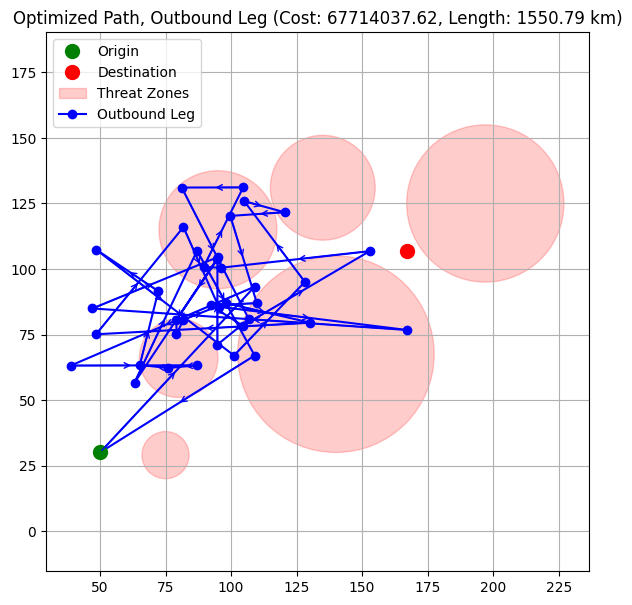

In [ ]:
# Plotting 128 iterations
out_waypoints = result.x.reshape(-1, 2)
full_path = np.vstack([origin, out_waypoints, origin])

plt.figure(figsize=(7, 7))

# Plot the path with arrows
path_line, = plt.plot(
    full_path[:, 0],  # X-coordinates of the path
    full_path[:, 1],  # Y-coordinates of the path
    'b-o', 
    label='Outbound Leg'
)

# Add direction arrows along the path
arrow_step = max(1, len(full_path) // (len(lb)//2))  
for i in range(0, len(full_path)-1, arrow_step):
    dx = full_path[i+1, 0] - full_path[i, 0]
    dy = full_path[i+1, 1] - full_path[i, 1]
    plt.annotate('', 
                xytext=(full_path[i, 0], full_path[i, 1]),
                xy=(full_path[i, 0] + 0.5*dx, full_path[i, 1] + 0.5*dy),
                arrowprops=dict(arrowstyle="->", color='blue', lw=1),
                )

origin_dot = plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin', linestyle='none')[0]
dest_dot = plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination', linestyle='none')[0]

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))

# Create a legend entry for threats (using Patch)
threat_patch = Patch(color='r', alpha=0.2, label='Threat Zones')

plt.legend(handles=[origin_dot, dest_dot, threat_patch, path_line], loc='upper left')
plt.axis('equal')
plt.grid()
plt.title(f"Optimized Path, Outbound Leg (Cost: {result.fun:.2f}, Length: {calculate_path_length(full_path):.2f} km)")
plt.show()